In [38]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from mrcnn.utils import Dataset, extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

import warnings
warnings.filterwarnings(action='once')

### Lets read the csv from the dataset

In [2]:

df = pd.read_csv("datasets/car_object_detection/data/train_solution_bounding_boxes (1).csv")

In [3]:
df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764800  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020261  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [4]:
# There are 559 images
df.shape

(559, 5)

In [5]:
df.nunique()

image    355
xmin     440
ymin     149
xmax     438
ymax     184
dtype: int64

In [6]:
# It looks like there are some images repeated, should be cause in some unique images there are several cars detected
df["image"].value_counts()

vid_4_26460.jpg    7
vid_4_6240.jpg     6
vid_4_26420.jpg    5
vid_4_26380.jpg    5
vid_4_6280.jpg     5
                  ..
vid_4_3460.jpg     1
vid_4_11400.jpg    1
vid_4_22700.jpg    1
vid_4_6520.jpg     1
vid_4_16020.jpg    1
Name: image, Length: 355, dtype: int64

(380, 676, 3)

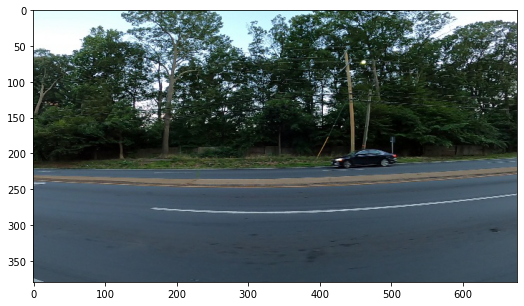

In [7]:
# Image checking
img = plt.imread("datasets/car_object_detection/data/training_images/" + df["image"][27])
plt.figure(figsize=(10,5))
plt.imshow(img)
img.shape

# 1. Mask R-CNN for car detection and segmentation:
The mask-rcnn lib requires to manage the data using the Dataset object (mrcnn.utils.Dataset). 
Let's create our class with inheritance, we need to use the built-in add_class() and add_image() functions. And also we need to define a function to load the data, for loading the mask and also for loading an image reference.


In [8]:
# This class defines and loads the car_object_detection Dataset with all the images and bboxes
class CarsDataset(Dataset):
    
    def load_dataset(self, dataset_dir="datasets/car_object_detection/data", mode='train'):
        # defining the class and the train/val proportion
        self.add_class("dataset",1,"car")
        
        # defining image info with built-in function
        if mode=='train':
            images_dir = dataset_dir + "/training_images/"
            for i in range(500):
                image_id = df.iloc[i,0]
                image_path = images_dir + image_id
                self.add_image("dataset", image_id=image_id, path=image_path)
        if mode=='val':
            images_dir = dataset_dir + "/training_images/"
            for i in range(500,df.shape[0]):
                image_id = df.iloc[i,0]
                image_path = images_dir + image_id
                self.add_image("dataset", image_id=image_id, path=image_path)
        if mode=='test':
            images_dir = dataset_dir + "/testing_images/"
            for filename in listdir(images_dir):
                image_id = filename
                image_path = images_dir + image_id
                self.add_image("dataset", image_id=image_id, path=image_path)
                
    def extract_boxes(self, image_id):
        #get coordinates from bboxes
        boxes = []
        xmin = int(df[df["image"]==image_id].iloc[0,1])
        ymin = int(df[df["image"]==image_id].iloc[0,2])
        xmax = int(df[df["image"]==image_id].iloc[0,3])
        ymax = int(df[df["image"]==image_id].iloc[0,4])
        boxes.append([xmin,ymin,xmax,ymax])
        # mrcnn needs the width and height from image values
        width = 380
        height = 676
        return boxes, width, height
    
    # This defines the mask, as a 2D array, with zeros in all the are, but ones when its detected the bbox
    def load_mask(self, image_id):
        image = self.image_info[image_id]["id"]
        boxes, w, h = self.extract_boxes(image)
        masks = np.zeros([w, h, len(boxes)], dtype='uint8')
        class_ids = []
        for i in range(len(boxes)):
            box = boxes[i]
            # Rows and columns start and end of the array
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('car'))
        return masks, np.asarray(class_ids, dtype='int32')
    
    # This function is responsible for returning the path or URL for a given "image_id"
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info["path"]
    

#### Let's load different datasets and convert into the class CarsDataset()

In [9]:
train = CarsDataset()
train.load_dataset(mode="train")
train.prepare()

test = CarsDataset()
test.load_dataset(mode="test")
test.prepare()

val = CarsDataset()
val.load_dataset(mode="val")
val.prepare()


#### Take a look to the images with the train solution bounding boxes turned into masks

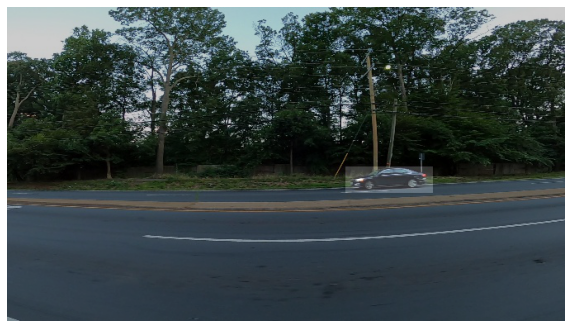

In [10]:
image_id = 27
img = train.load_image(image_id)
plt.figure(figsize=(10,8))
plt.imshow(img)
# plotting the mask
mask, class_id = train.load_mask(image_id)
plt.imshow(mask, cmap="gray", alpha=0.2)
plt.axis("off")
plt.show()

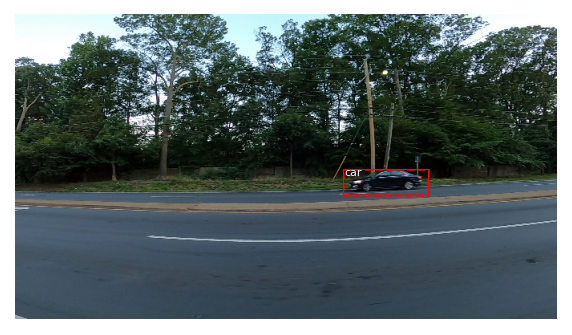

In [11]:
# Using built-in functions extract_bboxes() and display_instances() to show images
bbox = extract_bboxes(mask)
display_instances(img, bbox, mask, class_id, train.class_names, figsize=(10,8), show_mask=False)

# 2. It's time to TRAIN the Model for Car Detection

To train the model on our own dataset we'll need to extend also the Config() class. This class contains the default configuration. We need to subclass it and modify the attributes we need to change.

In [12]:
# There are a lot of parameters to tweak
class CarConfig(Config):
    NAME = "Car"
    # Number of classification classes (including background)
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 200
    #LEARNING_RATE = 0.002

In [13]:
config = CarConfig()

In [ ]:
# Model with built-in class object
model = MaskRCNN(mode="training", model_dir="model/", config=config)

### Loading weights to the model

The Mask R-CNN model pre-fit on the MS COCO object detection dataset can be used as a starting point We first need to download the model file (architecture and weights) for the pre-fit Mask R-CNN model from the GitHub project releases https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
# we exclude class-specific output layers that we'll define and train with our dataset
# model.load_weights("model/mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# Training the model with train and validation data
# model.train(train, val, learning_rate=config.LEARNING_RATE, epochs=10, layers="heads")

### Taking the model already trained through colab and evaluated

In [ ]:
# This is mask_rcnn_car_0009.h5

In [17]:
# To evaluate the model we need to create a new config object to make some predictions instead of training
class CarPredictionConfig(Config):
    NAME = "car_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [18]:
predconfig = CarPredictionConfig()

In [19]:
model = MaskRCNN(mode="inference", model_dir="model/pred/", config=predconfig)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [23]:
# load weights from previously trained model
model.load_weights("model/mask_rcnn_car_0009.h5", by_name=True)

In [ ]:
# Load image with built-in function load_image_gt() to load images and mask from ground truth
image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(train, predconfig, image_id, use_mini_mask=False)
scaled_image = mold_image(image, predconfig)
sample = np.expand_dims(scaled_image, 0)

In [41]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		id = np.random.randint(0,len(dataset.image_ids))
		# load the image and mask
		image = dataset.load_image(id)
		mask, _ = dataset.load_mask(id)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = np.expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		plt.figure(figsize=(60,60))
		plt.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		plt.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Predicted')
		ax = plt.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	plt.show()

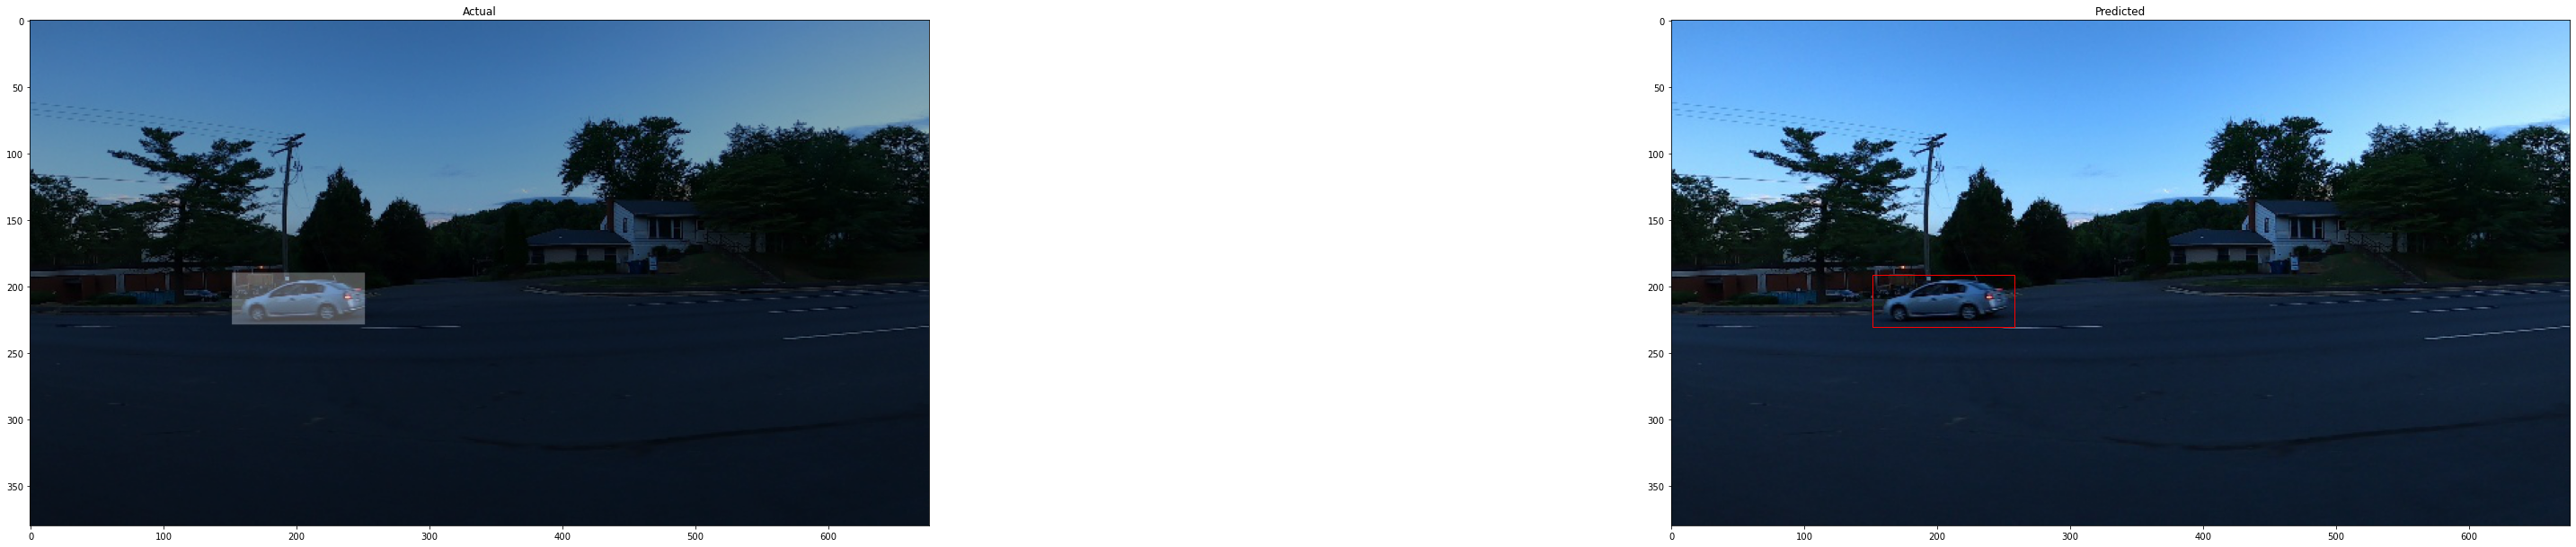

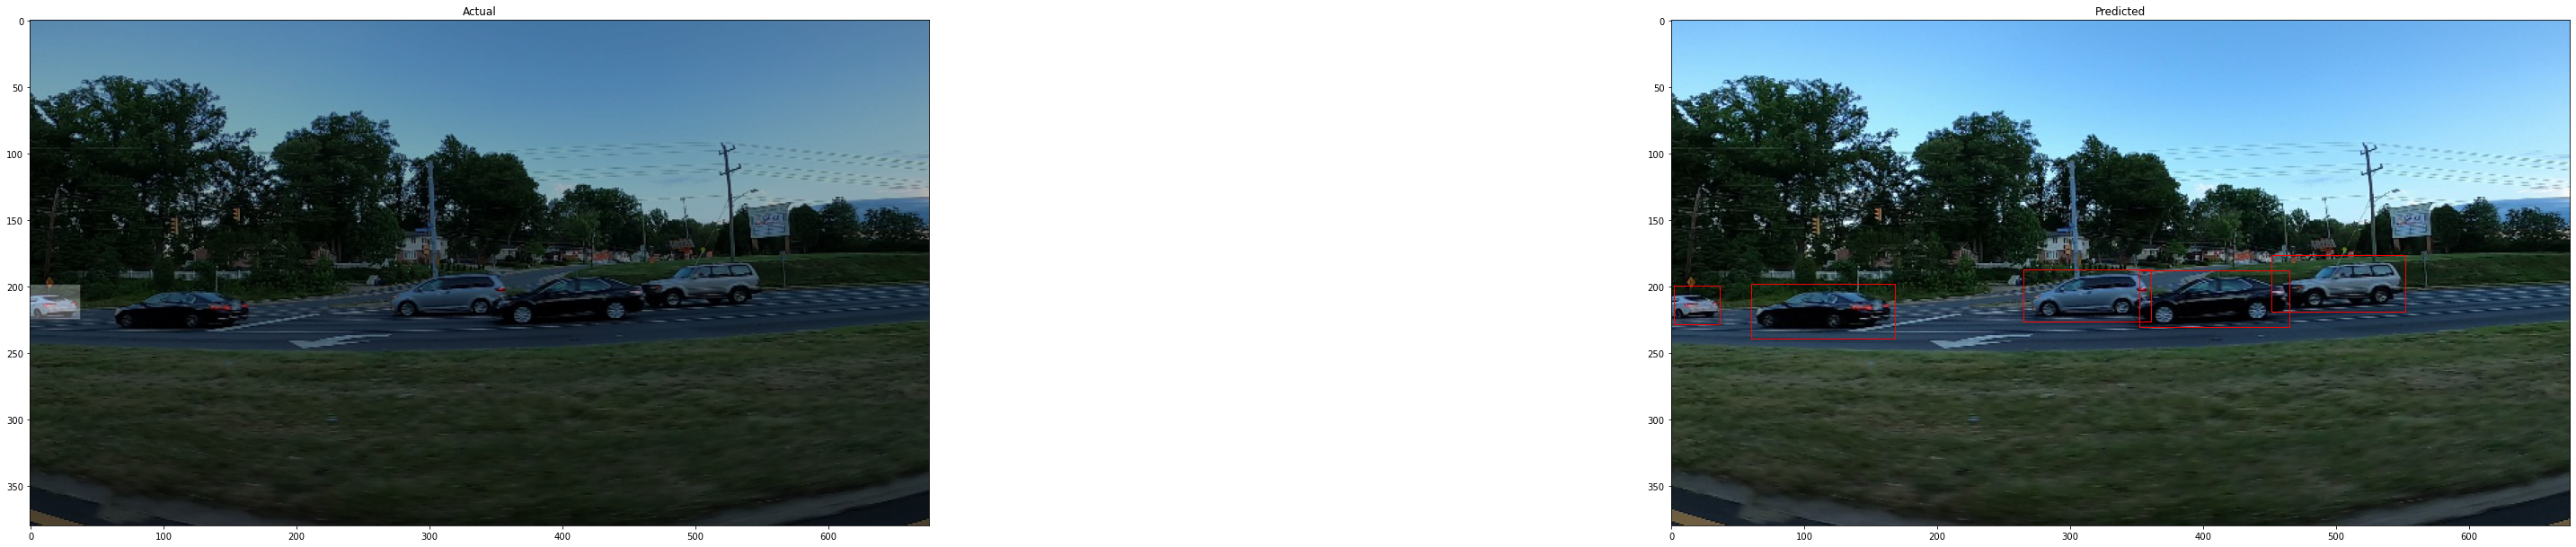

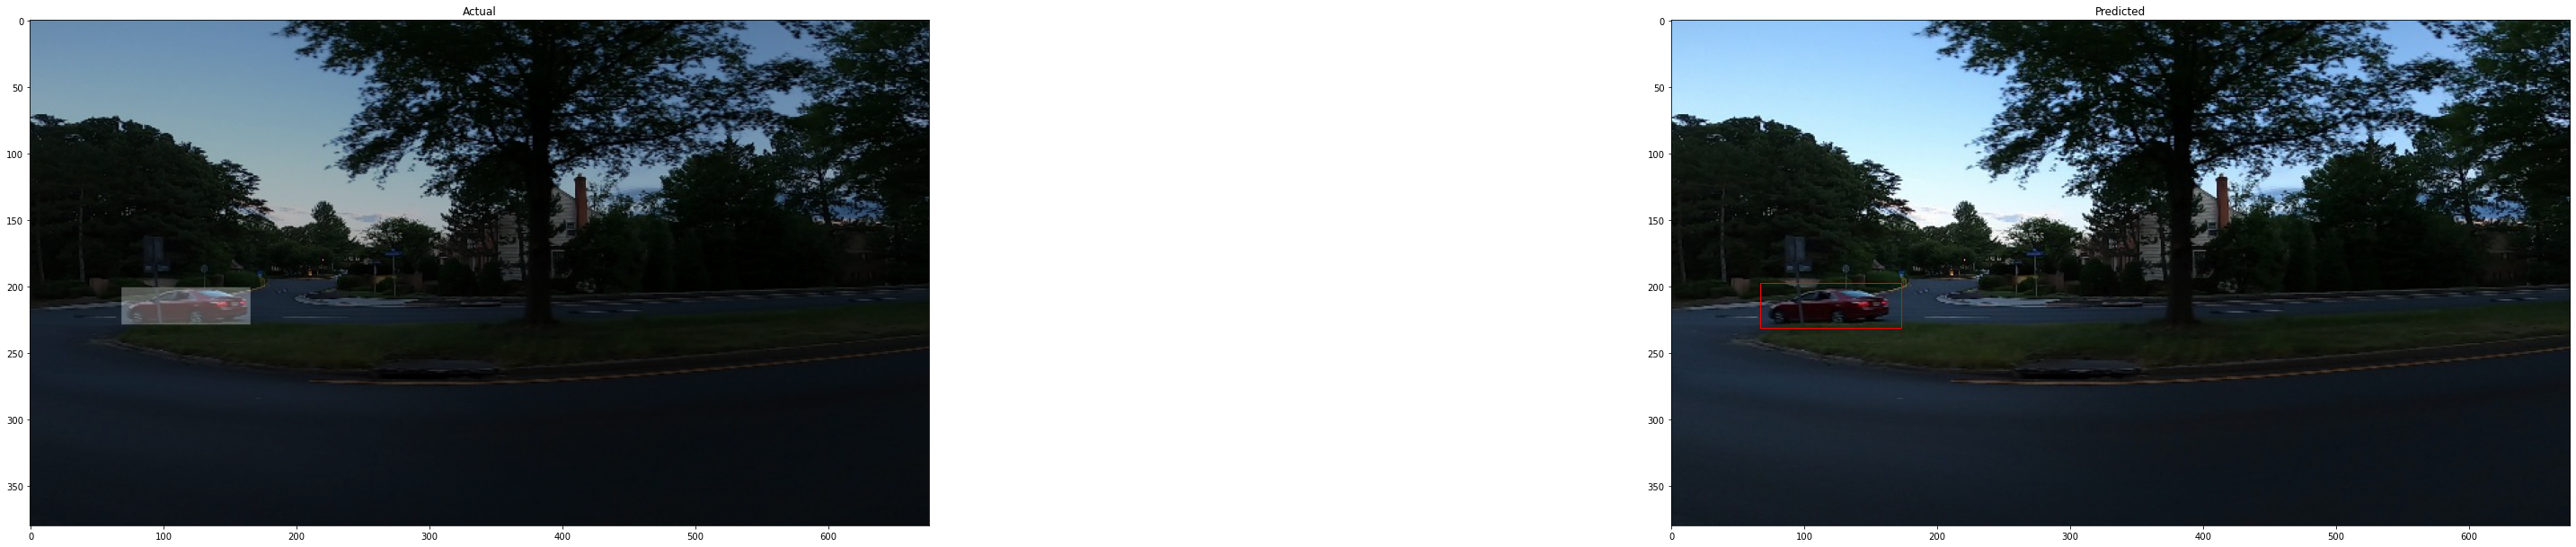

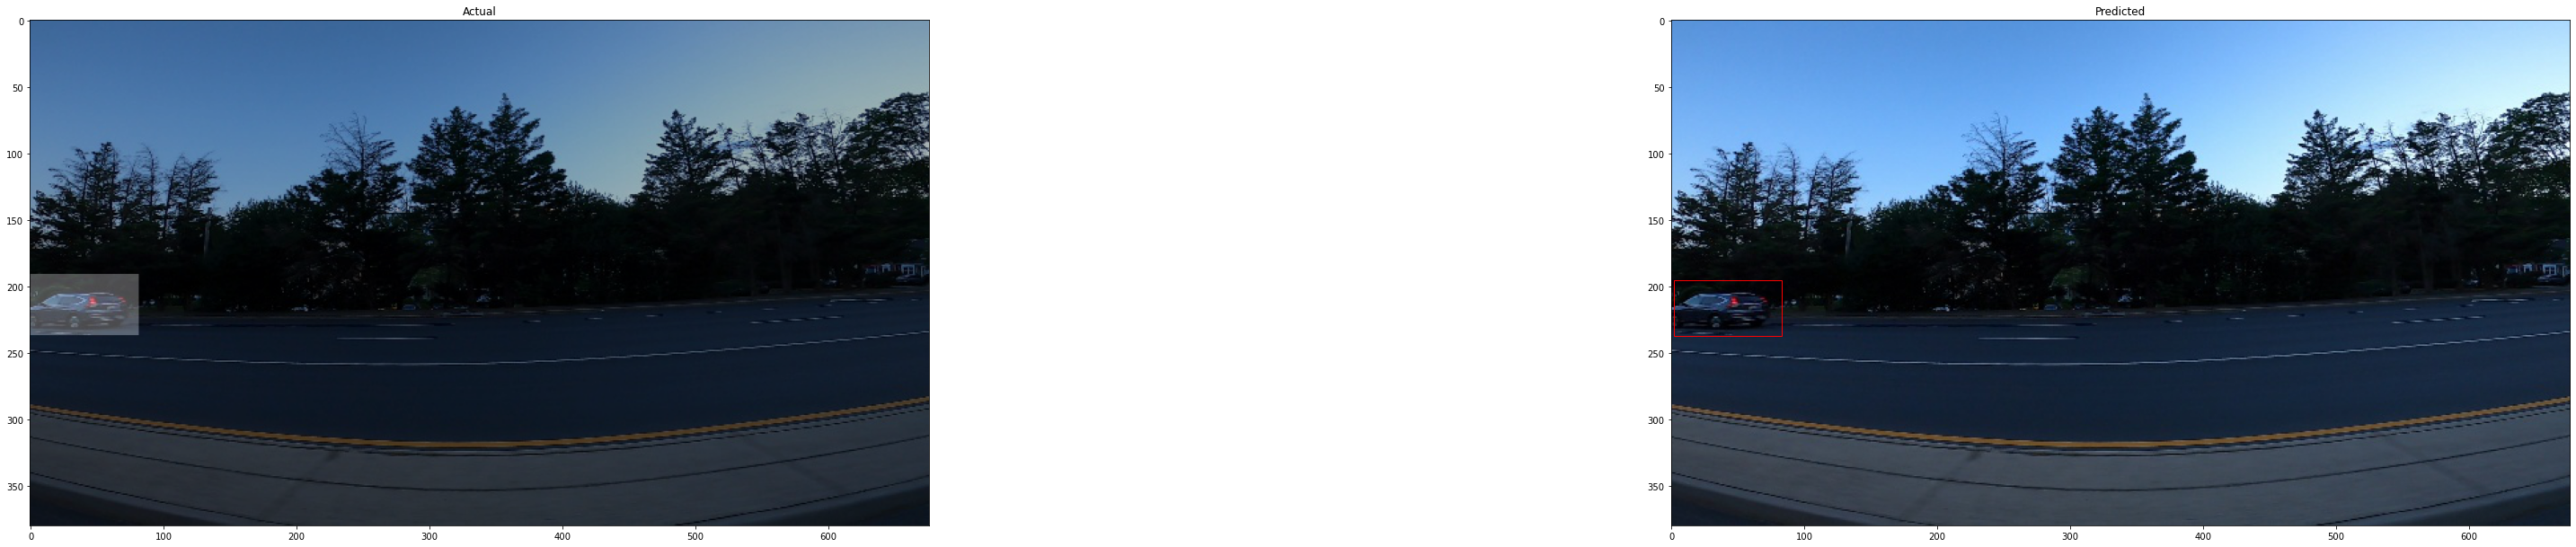

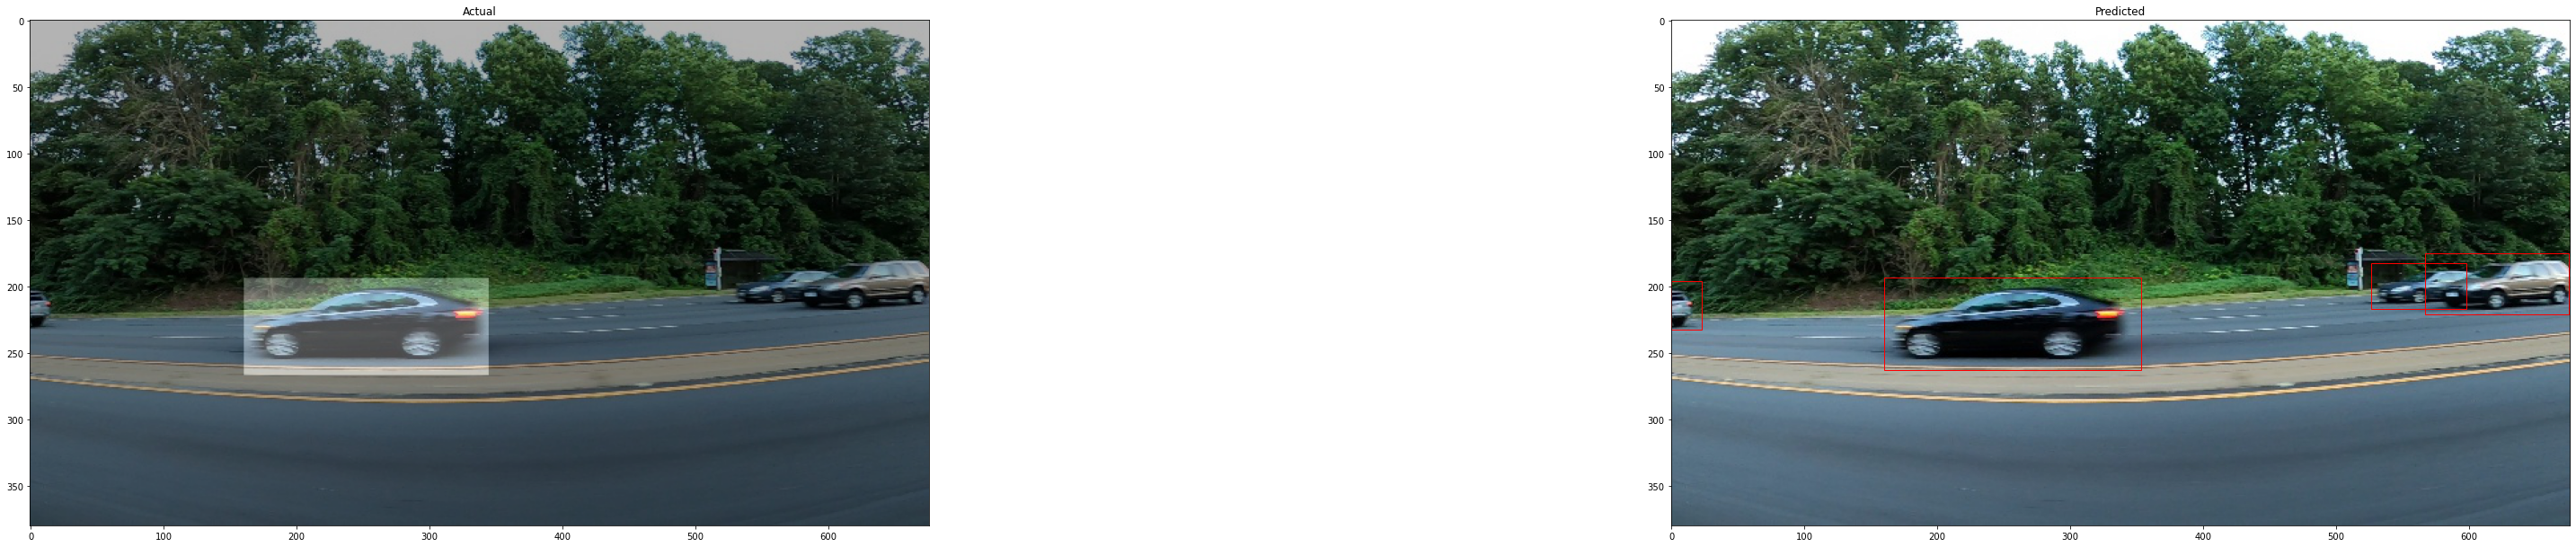

In [42]:
plot_actual_vs_predicted(train, model, predconfig)